## Vector Search on Image: Azure Cognitive Search via Python SDK

### Load environment variables

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

acs_key  = os.getenv("COGNITIVE_SEARCH_KEY")
if acs_key is None or acs_key == "":
    print("COGNITIVE_SEARCH_KEY environment variable not set.")
    exit()

aoai_key  = os.getenv("AZURE_OPENAI_KEY")
if aoai_key is None or aoai_key == "":
    print("AZURE_OPENAI_KEY environment variable not set.")
    exit()

com_vision_key  = os.getenv("COMPUTER_VISION_KEY")
if com_vision_key is None or com_vision_key == "":
    print("COMPUTER_VISION_KEY environment variable not set.")
    exit()

index_name = 'image-sample'
acs_endpoint = 'https://cogsearch02.search.windows.net'
acs_index_definition = 'index_definition/index_definition_image.json'
acs_api_version = '2023-07-01-Preview'
aoai_endpoint = 'https://azure-openai-dnai.openai.azure.com'
aoai_api_version = '2023-08-01-preview'
aoai_embedding_deployed_model = 'embedding-ada'
com_vision_endpoint='https://comvis007.cognitiveservices.azure.com'

### Helper methods

In [ ]:
from azure.search.documents.indexes import SearchIndexClient, SearchIndexerClient
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes.models import (
    SimpleField,
    SearchField,
    SearchableField,
    SearchFieldDataType,
    VectorSearch,  
    HnswVectorSearchAlgorithmConfiguration,  
    SemanticSettings,
    SemanticConfiguration,
    PrioritizedFields,
    SemanticField,
    SearchIndex
)

def get_index_client() -> SearchIndexClient:
    return SearchIndexClient(acs_endpoint, AzureKeyCredential(acs_key))

def create_index(index_name, fields, vector_search, semantic_title_field_name, semantic_content_field_names):
    semantic_settings = SemanticSettings(
        configurations=[SemanticConfiguration(
            name='default',
            prioritized_fields=PrioritizedFields(
                title_field=SemanticField(field_name=semantic_title_field_name), prioritized_content_fields=[SemanticField(field_name=field_name) for field_name in semantic_content_field_names]))])
    index = SearchIndex(
        name=index_name,
        fields=fields,
        vector_search=vector_search,
        semantic_settings=semantic_settings)
    index_client = get_index_client()
    return index_client.create_index(index)

def vectorize_text_com_vision(com_vision_endpoint,com_vision_key,query):
    vectorize_text_url = f"{com_vision_endpoint}/computervision/retrieval:vectorizeText"  
    params = {  
        "api-version": "2023-02-01-preview"  
    } 
    headers = {  
        "Content-Type": "application/json",  
        "Ocp-Apim-Subscription-Key": com_vision_key  
    }  
    data = {
        'text':query
    }

    response = requests.post(vectorize_text_url, params=params, headers=headers, json=data)
    query_vector = response.json()["vector"]

    return query_vector

def show_image(image_folder, image):
    image_path = os.path.join(image_folder, image)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()

### Create ACS index

In [ ]:
vector_search = VectorSearch(
    algorithm_configurations=[
        HnswVectorSearchAlgorithmConfiguration(
            name="vector_config",
            kind="hnsw",
            parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 1000,
                "metric": "cosine"
            }
        )
    ]
)
fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True),
    SearchableField(name="image", type=SearchFieldDataType.String),
    SearchField(name="image_vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single), searchable=True, vector_search_dimensions=1024, vector_search_configuration="vector_config")   
]

index = create_index(index_name, fields, vector_search=vector_search, semantic_title_field_name="image", semantic_content_field_names=["image"])

### Create embeddings

In [ ]:
import os
import requests
import pandas as pd

image_folder = "../../data/images"
image_list = os.listdir(image_folder)
df = pd.DataFrame(columns=['image', 'image_vector'])

for image_name in image_list:
    image_path = os.path.join(image_folder, image_name)

    with open(image_path, "rb") as binary_file:
        binary_data = binary_file.read()
        
        vectorize_img_url = f"{com_vision_endpoint}/computervision/retrieval:vectorizeImage"  
        params = {  
            "api-version": "2023-02-01-preview"  
        } 
        headers = {  
            "Content-Type": "image/jpeg",  
            "Ocp-Apim-Subscription-Key": com_vision_key  
        }  

        response = requests.post(vectorize_img_url, params=params, headers=headers, data=binary_data)

        df_row = {'image':image_name, 'image_vector':response.json()["vector"]}
        df = pd.concat([df, pd.DataFrame([df_row])], ignore_index=True)

df['id'] = df.index
print(df.head())

### Ingest to azure cognitive search

This cell works because the dataframe and the ACS Index both have same columns. If the dataframe doesn't have the same columns (column names or numbers) as the ACS Index, add a preprocessing step to it to structure the dataframe according to the ACS columns.

In [ ]:
import os
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient

batch_size = 10
total_records = df.shape[0]
fields = df.columns.to_numpy()
df['id'] = df['id'].astype(str)

records = []

for index, row in df.iterrows():
    record = {}
    for field in fields:
            record[field] = row[field]

    records.append(
        record
    )

    if index % batch_size == 0 or (index+1 == total_records):
        search_client = SearchClient(acs_endpoint, index_name, AzureKeyCredential(acs_key))
        result = search_client.upload_documents(documents=records)
        records = []


### Perform a vector similarity search

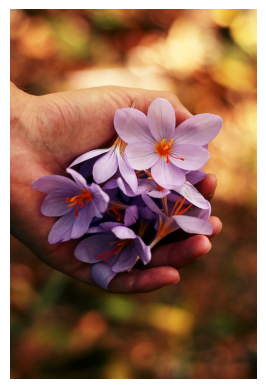

In [50]:
import matplotlib.pyplot as plt
from PIL import Image
from azure.search.documents.models import Vector  

query = 'flower with hand'

query_vector = vectorize_text_com_vision(com_vision_endpoint,com_vision_key,query)

search_client = SearchClient(acs_endpoint, index_name, AzureKeyCredential(acs_key))
vector = Vector(value=query_vector, k=1, fields="image_vector")  

results = search_client.search(  
    search_text=None,  
    vectors=[vector],
    select=["image"]  
)   

for result in results:
    show_image(image_folder, result['image'])
    print("\n")